<a href="https://colab.research.google.com/github/jjiguaran/text_mining/blob/master/individual_versions/Topics_noticias_reddit_juanjo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
import gensim
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pickle
import random
import sys
from tqdm import tqdm
from sklearn import manifold
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold

[nltk_data] Downloading package punkt to /home/juan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/juan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Importar los datasets
url_reddit = 'https://raw.githubusercontent.com/jjiguaran/text_mining/master/Data/RedditNews.csv'
url_combined = 'https://raw.githubusercontent.com/jjiguaran/text_mining/master/Data/Combined_News_DJIA.csv'
RedditNews = pd.read_csv(url_reddit)
CombinedNews = pd.read_csv(url_combined)


RedditNews['Date'] =  pd.to_datetime(RedditNews['Date'], format='%Y-%m-%d')
CombinedNews['Date'] =  pd.to_datetime(CombinedNews['Date'], format='%Y-%m-%d')


In [ ]:
# Exploramos redditnews
RedditNews.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [ ]:
# Exploramos combinedNews
CombinedNews.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

Analizar la distribución de clases

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,count
Label,
0,924
1,1065


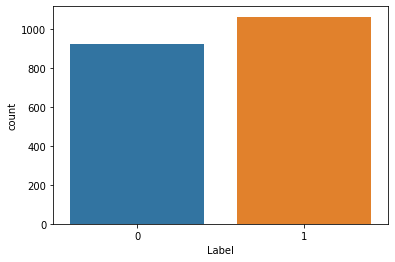

In [ ]:
## Distribución de clases
import seaborn as sns

display( CombinedNews.groupby(['Label'])['Date'].agg(['count']))
sns.countplot(x='Label', data=CombinedNews)

Analizar cantidad de noticias, pueden haber días sin el todo el top 25

In [ ]:
## Ver si hay días que no tienen 25 noticias 
nulls_by_col = CombinedNews.isnull().sum().reset_index()
nulls_by_col[nulls_by_col[0]>0]

,index,0
24,Top23,1
25,Top24,3
26,Top25,3


In [ ]:
CombinedNews[pd.isnull(CombinedNews['Top25'])]
## 3 días no tienen ni top 24 ni top 25, y uno de esos tampoco tiene top 23

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
277,2009-09-15,1,b'The Church of Scientology won\'t be dissolve...,b'New virus from rats can kill 80 per cent of ...,b'The gruesome spectacle of dolphins being sla...,b'The End of Innocence in Afghanistan: \'The G...,b'France approves Internet piracy bill',b'The Rural Doctors Association says right now...,b'Al Jazeera English - Africa - Shabab to aven...,"b""How Sri Lanka governs through detentions - S...",b'Two months after the Pakistani Army wrested ...,b'N. Korean cargo ship repels pirates off Soma...,b'Canada: Stephen Harper attempts to prop up r...,b'New geological data provides hope for claims...,b'Ukraine set to block Elton John adoption bec...,b'German plane makes emergency landing',b'Street artist catches chief of the Israeli a...,b'In an equine echo of the controversy surroun...,b'UPDATE: 5-New York homes raided in terrorism...,b'Population Growth Impeding Progress on the M...,b'Global Population to Reach 7 Billion by 2011',b'Government Funded Feminist Porn ',b'Can someone enlighten me re:Holy Land disput...,b'Human Rights Watch official suspended for co...,NaN,NaN,NaN
348,2009-12-24,1,b'Woman knocks down Pope Benedict at Christmas...,b'Ugandan President Museveni says he will bloc...,"b""Venezuela's Chavez threatens to kick out car...",b'Woman who knocked down pope had pasta in her...,"b'450 people from 21 countries, including 30 f...",b'Chvez declares Angel Falls is no more: World...,b'Drug tests catch out 10 police (UK)',"b'Once the worlds fourth-largest lake, the Ara...","b""Cool Saudi Feminist calls for woman's right ...","b'According to satellite surveys, as much as 8...",b'Italian Prime Minister Silvio Berlusconi has...,"b""Don't blame the system for winter travel cha...",b'Christmas Eve around the world included the ...,b'Pope knocked down before Xmas mass',b'The solar salesman who put his cow on the ma...,b'Pig farts spark Australia gas scare - I shit...,b'Bin Laden daughter flees to Saudi embassy in...,b'Traumatic Brain Injuries: Growing evidence ...,b'The Pakistan Supreme Court has ordered the P...,"b""Here's a video the Taliban released this mor...",b'Fireworks set off aboard airliner',"b'Five VA men may face terrorism charges, Paki...","b""Ayatollah Montazeri's Legacy: In death he m...",NaN,NaN
681,2011-04-21,1,"Director of ""Restrepo"" and Photographer Chris ...",Everyone within 20km of Fukushima will be forc...,Bahrain: Activist Zaynab Al-Khawaja's letter t...,"More than 80,000 people are claiming incapacit...",Libya: 'mission creep' claims as UK sends in m...,Japan considers banning access to evacuation zone,Chinese oil giant Sinopec has stopped exportin...,6.0-magnitude earthquake strikes off east coas...,Next war in line: At least 20 South Sudanese a...,Bahraini protester ends hunger strike after be...,China tries to scare motorists into safer driving,Leaked Report Shows England Hit With Three Nuc...,Japans cyclone season approaches.,Have Oman and Qatar escaped the Arab revolts?,Rioters torch Australia asylum seeker detentio...,Russian migration official fired in racism row...,Small amounts of radioactive iodine found in b...,"War photographer, Oscar-nominated film directo...",Effeminate boys are being sent to a special ca...,Japan Government Declares 12-Mile Area Around ...,TEPCO admitted Wednesday that nuclear fuel in ...,Fukushima evacuees face arrest if they return ...,Prince Charles wins some kind of a record,NaN,NaN


In [ ]:
## Vamos a comprobar que en el el dataset que están todas las noticias se tenga el mismo numero
news_by_day = RedditNews.groupby(['Date']).agg('count')
news_by_day[news_by_day['News']!=25]


,News
Date,
2009-09-15,22
2009-12-24,23
2011-04-21,23


Añadir el numero del top correspondiente a las noticias, y la etiqueta del día

In [3]:
## Añadir columna del top correspondiente
RedditNews['Top'] = RedditNews.groupby(['Date']).cumcount()+1

## Añadir columna de la clase a este df
RedditNews = pd.merge(RedditNews, CombinedNews[['Date','Label']], on=['Date'])

RedditNews[RedditNews['Date']=='2016-07-01']

,Date,News,Top,Label
0,2016-07-01,A 117-year-old woman in Mexico City finally re...,1,1
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,2,1
2,2016-07-01,"The president of France says if Brexit won, so...",3,1
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...,4,1
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...,5,1
5,2016-07-01,Brazil: Huge spike in number of police killing...,6,1
6,2016-07-01,Austria's highest court annuls presidential el...,7,1
7,2016-07-01,"Facebook wins privacy case, can track any Belg...",8,1
8,2016-07-01,Switzerland denies Muslim girls citizenship af...,9,1
9,2016-07-01,China kills millions of innocent meditators fo...,10,1


Limpieza de los datos

In [8]:
## Hay error en la codificación de caracteres especiales, encontré ese, pero hay que ver que otros surgen
index_review = RedditNews[RedditNews['News'].str.contains('&amp;')].index
display(RedditNews[RedditNews['News'].str.contains('&amp;')])
RedditNews['News'] = RedditNews['News'].str.replace('&amp;', '&')

,Date,News,Top,Label
16,2016-07-01,S&amp;P revises European Union credit rating t...,17,1
24,2016-07-01,Ozone layer hole seems to be healing - US &amp...,25,1
53,2016-06-29,Devastated: scientists too late to captive bre...,4,1
77,2016-06-28,S&amp;P cuts United Kingdom sovereign credit r...,3,1
181,2016-06-22,Police kill eight striking Mexican teachers as...,7,0
...,...,...,...,...
49043,2008-09-16,"b""Pakistani Tribesmen Representing Half A Mill...",1,1
49140,2008-09-11,b'BREAKING: Tsunami Alerts - Japan &amp; Indon...,23,1
49420,2008-08-25,b'Israel claims allowing an aid ship to reach ...,3,0
49476,2008-08-21,"b""China sentences Alive in Baghdad blogger, GR...",9,1


In [ ]:
## Acá se ven corregidos ya
RedditNews[RedditNews.index.isin(index_review)]

,Date,News,Top,Label
16,2016-07-01,S&P revises European Union credit rating to 'A...,17,1
24,2016-07-01,Ozone layer hole seems to be healing - US & UK...,25,1
53,2016-06-29,Devastated: scientists too late to captive bre...,4,1
77,2016-06-28,S&P cuts United Kingdom sovereign credit ratin...,3,1
181,2016-06-22,Police kill eight striking Mexican teachers as...,7,0
...,...,...,...,...
49043,2008-09-16,"b""Pakistani Tribesmen Representing Half A Mill...",1,1
49140,2008-09-11,b'BREAKING: Tsunami Alerts - Japan & Indonesia...,23,1
49420,2008-08-25,b'Israel claims allowing an aid ship to reach ...,3,0
49476,2008-08-21,"b""China sentences Alive in Baghdad blogger, GR...",9,1


In [4]:
import re
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words("english")
REPLACE_BY_SPACE_RE = re.compile('[(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z ^#\+_]')
SEP_NUMBER = re.compile('(?<=\d)\,|\.(?=\d)')
USA_ABREV = re.compile('U\.S|u\.s\|u\.s\.a\.|US')
DOT_ABREV = re.compile('\.(?![a-zA-Z]{2})')
STARTING_B = re.compile("^\"b' |^b ")
STOPWORDS = stopwords.words('english')

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    
    text = USA_ABREV.sub(' usa ', text) # replace U.S U.S. u.s US for usa
    text = text.lower() # lowercase text
    text = text.replace("al-qaeda", "alqaeda")
    text = text.replace("al-qa'eda", "alqaeda")
    text = text.replace('&amp;', '&')
    text = text.replace('&', '')    

    text = DOT_ABREV.sub('', text) # removes abrevetion dot, ej: L.G.B.T  = LGBT
    text = SEP_NUMBER.sub('', text) # removes . and , seprating numbers
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub(' ', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = STARTING_B.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text

    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = text.strip()
    return text
    
RedditNews['News_cleaned'] = RedditNews['News'].apply(clean_text)
RedditNews

,Date,News,Top,Label,News_cleaned
0,2016-07-01,A 117-year-old woman in Mexico City finally re...,1,1,117 year old woman mexico city finally receive...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,2,1,imf chief backs athens permanent olympic host
2,2016-07-01,"The president of France says if Brexit won, so...",3,1,president france says brexit donald trump
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...,4,1,british man must give police 24 hours notice s...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...,5,1,100+ nobel laureates urge greenpeace stop oppo...
...,...,...,...,...,...
49713,2008-08-08,b'Why the Pentagon Thinks Attacking Iran is a ...,21,0,pentagon thinks attacking iran bad idea usa ne...
49714,2008-08-08,b'Caucasus in crisis: Georgia invades South Os...,22,0,caucasus crisis georgia invades south ossetia
49715,2008-08-08,b'Indian shoe manufactory - And again in a se...,23,0,indian shoe manufactory series like work
49716,2008-08-08,b'Visitors Suffering from Mental Illnesses Ban...,24,0,visitors suffering mental illnesses banned oly...


In [5]:
joined_data = RedditNews.groupby(['Date', 'Label'])['News_cleaned'].apply(' '.join).reset_index()

In [13]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2020-05-10 21:02:24--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.77.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.77.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1,5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1,53G  4,80MB/s    in 6m 0s   

2020-05-10 21:08:25 (4,36 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [6]:
url = 'GoogleNews-vectors-negative300.bin.gz'
embeddings = gensim.models.KeyedVectors.load_word2vec_format(url, binary=True)

In [10]:
docs_vectors = pd.DataFrame() # creating empty final dataframe
docs_vectors_2 = pd.DataFrame()
stopwords = nltk.corpus.stopwords.words('english')
count = 0# removing stop words
for doc in joined_data['News_cleaned']: # looping through each document and cleaning it
    temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc.split(' '): # looping through each word of a single document and spliting through space
        if word not in stopwords: # if word is not present in stopwords then (try)
            try:
                word_vec = embeddings[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                temp = temp.append(pd.Series(word_vec), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
    doc_vector = temp.mean() # take the average of each column(w0, w1, w2,........w300)
    doc_vector_2 = temp.sum(axis = 0)
    docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
    docs_vectors_2 = docs_vectors_2.append(doc_vector_2, ignore_index = True)
    count += 1
    print(count)
docs_vectors.shape

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


(1989, 300)

In [20]:
docs_vectors['Label'] = joined_data['Label']
docs_vectors['Date'] = joined_data['Date']

In [23]:
docs_vectors_2['Label'] = joined_data['Label']
docs_vectors_2['Date'] = joined_data['Date']

In [25]:
 docs_vectors_2.to_csv('embeddings_sum.csv')

In [26]:
 docs_vectors.to_csv('embeddings_average.csv')

Aplicación de Naive Bayes

In [ ]:
# Separamos en train y test

X = RedditNews.News_cleaned
y = RedditNews.Label
X_train_text, X_test_text, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.20, random_state=1234)

In [ ]:
# Limpieza del texto
def clean_text(text):
  # En este caso particular no hace falta limpiar los textos
   return text.strip()

In [ ]:
def tokenizer(text):
    #return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras
    return word_tokenize(text)
tokenizer(clean_text(X_train_text.iloc[2]))[:10]

['g7', 'leaders', 'agree', 'to', 'phase', 'out', 'fossil', 'fuel', 'use', 'by']

Extarcción de features

In [ ]:
stoplist = stopwords.words("english")

# tokenizo el stoplist con el mismo tokenizar que voy a usar en el corpus
stoplist_tokenized = []
for w in stoplist:
    stoplist_tokenized = stoplist_tokenized + tokenizer(w)

In [ ]:
# Armo una lista sin repeticiones
stoplist_tokenized = list(set(stoplist_tokenized))

In [ ]:
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=tokenizer, min_df=5,stop_words=stoplist_tokenized)
X_train = count_vect.fit_transform(X_train_text) # cuenta frecuencia de tokens y define el diccionario
X_test = count_vect.transform(X_test_text) # cuenta frecuencia de tokens existentes en el diccionario
X_train

<39774x10330 sparse matrix of type '<class 'numpy.int64'>'
	with 437640 stored elements in Compressed Sparse Row format>

In [ ]:
trainset = []
for rev in X_train_text:
  #rev = rev.decode('utf-8').lower()
  # clean review
  #rev = re.sub('<.*?>',' ',rev)
  #split by sentence
  sentences = sent_tokenize(rev)
  for sent in sentences:
    # word tokenize and append the sentence as a list of words
    trainset.append([word for word in word_tokenize(sent) if word.isalpha()])

In [17]:
print("el corpus tiene",len(trainset), "oraciones y",sum([len(x) for x in trainset]),"palabras"   )

el corpus tiene 39774 oraciones y 709898 palabras


In [ ]:
collocations = Phrases(sentences=trainset, min_count=10,threshold=0.5,scoring='npmi')

In [ ]:
to_collocations = Phraser(collocations)

In [20]:
df_collocations =pd.DataFrame([x for x in collocations.export_phrases(trainset)],columns=["bigram","score"])
df_collocations.shape

(28202, 2)

In [21]:
df_collocations.drop_duplicates().sort_values(by="score",ascending=False).head(50)

,bigram,score
8518,b'buenos aires',1.000000
118,b'tel aviv',1.000000
195,b'suu kyi',1.000000
301,b'dalai lama',0.998033
614,b'sierra leone',0.995539
3320,b'rebekah brooks',0.995539
3,b'hong kong',0.995256
156,b'wal mart',0.994628
889,b'mein kampf',0.993632
254,b'boko haram',0.992332


In [ ]:
trainset_ngrams = to_collocations[trainset]

In [ ]:
w2v_model = Word2Vec(trainset_ngrams, workers=4,size=20, min_count = 10, window = 10, sample = 1e-3,negative=5,sg=1)